In [1]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-kv14tw8h/polara_e1d8fd0d3a524520949e875f4244f4fb
  Running command git clone --filter=blob:none -q https://github.com/evfro/polara.git /tmp/pip-install-kv14tw8h/polara_e1d8fd0d3a524520949e875f4244f4fb
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit ef7a5360e3f9793f4f0fdd4f31e32399d2e52069
  Preparing metadata (setup.py) ... done


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix, coo_matrix, diags

from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

from source.dataprep.dataprep import transform_indices, generate_interactions_matrix
from source.evaluation.evaluation import topn_recommendations, model_evaluate, downvote_seen_items, build_evaluate_model
from source.helpers.knn import truncate_similarity
from source.helpers.similarity import jaccard_similarity, weighted_jaccard_similarity
from source.helpers.plot import plot_histories
from source.models.basic import Random, Popular
from data import get_dataset
# %cd -

In [ ]:
# training, data_description, testset_valid, testset, holdout_valid, holdout = get_dataset(validation_size=1024, test_size=5000, splitting='temporal_full',
#                                                                                      q=0.8)
# data_description

In [3]:
training = pd.read_csv('../sasrec_zvuk/training_temp.csv')
testset_valid = pd.read_csv('../sasrec_zvuk/testset_valid_temp_cut.csv')
holdout_valid = pd.read_csv('../sasrec_zvuk/holdout_valid_temp_cut.csv')
testset = pd.read_csv('../sasrec_zvuk/testset.csv')
data_description = {'users': 'userid',
 'items': 'itemid',
 'order': 'timestamp',
 'n_users': training.userid.nunique(),
 'n_items': training.itemid.max()
}

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [4]:
from polara.preprocessing.dataframes import reindex, leave_one_out

test_size = 5000

testset, holdout = leave_one_out(
            testset, target='timestamp', sample_top=True, random_state=0
        )

test_users = np.intersect1d(holdout['userid'].unique(), testset['userid'].unique())
if test_size < len(test_users):
    test_users  = np.random.choice(test_users, size=test_size, replace=False)
testset = testset[testset['userid'].isin(test_users)].sort_values(by=['userid', 'timestamp'])
holdout = holdout[holdout['userid'].isin(test_users)].sort_values(['userid'])

In [5]:
data_description['timestamp'] = 'timestamp'
data_description

{'users': 'userid',
 'items': 'itemid',
 'order': 'timestamp',
 'n_users': 1078263,
 'n_items': 232273,
 'timestamp': 'timestamp'}

In [6]:
data_description['n_items'] = 232273 + 1

In [7]:
print(training["itemid"].max())
print(testset_valid["itemid"].max())

232273
232228


In [8]:
testset

,userid,itemid,timestamp,playevent_play_duration,day
19784696,652,121320,1.729517e+15,156,2024-10-21
20758254,652,899,1.729518e+15,114,2024-10-21
18874238,652,899,1.729518e+15,176,2024-10-21
19847600,652,181129,1.729518e+15,251,2024-10-21
20449554,652,232180,1.729518e+15,102,2024-10-21
...,...,...,...,...,...
24254468,2454609,126748,1.729608e+15,219,2024-10-22
24254470,2454609,156970,1.729608e+15,212,2024-10-22
24254475,2454609,175037,1.729608e+15,192,2024-10-22
24254467,2454609,214755,1.729609e+15,185,2024-10-22


In [9]:
holdout

,userid,itemid,timestamp,playevent_play_duration,day
6160529,652,7222,1.729932e+15,153,2024-10-26
5002005,1586,9639,1.729846e+15,83,2024-10-25
24260577,1936,175353,1.729879e+15,198,2024-10-25
23665865,2725,228782,1.729697e+15,41,2024-10-24
46223984,2940,9464,1.729856e+15,213,2024-10-25
...,...,...,...,...,...
920190,2453348,212869,1.729857e+15,135,2024-10-28
35064995,2453784,173832,1.729900e+15,82,2024-10-26
2620514,2453994,48886,1.729763e+15,233,2024-10-24
4497645,2454411,185746,1.729905e+15,64,2024-10-27


# Jaccard similarity

In [3]:
def jaccard_similarity(A, B):
    '''
    Computes the jaccard similarity index between the rows of two input matrices.
    The matrices are binarized.
    Jaccard(u, v) = \frac{\sum_{i=1}^k \min(u_k, v_k)}{\sum_{i=1}^k \max(u_k, v_k)}
    
    Args:
        A (scipy.sparse.csr_matrix): n_users_A x n_items
        B (scipy.sparse.csr_matrix): n_users_B x n_items

    Returns:
        scipy.sparse.csr_matrix: A sparse matrix of shape (n_users_A, n_users_B) containing the similarities between users
    '''
    assert A.shape[1] == B.shape[1]
    A_bin = A.astype('bool').astype('int')
    B_bin = B.astype('bool').astype('int')

    numerator = A_bin @ B_bin.T
    denominator = A_bin.sum(axis=1) + B_bin.sum(axis=1).T - A_bin @ B_bin.T
    similarity = csr_matrix(numerator / denominator)
    return similarity

In [4]:
def compute_similarity(type, m1, m2):
    if type == 'jaccard':
        similarity = jaccard_similarity(m1, m2)
    elif type == 'weighted_jaccard':
        similarity = weighted_jaccard_similarity(m1, m2)
    elif type == 'cosine':
        similarity = cosine_similarity(m1, m2, dense_output=False)
    else:
        raise ValueError(f'Unknown similarity type: {type}')
    return similarity

# KNN

In [5]:
def generate_sequential_matrix(data, data_description, rebase_users=False):
    '''
    Converts a pandas dataframe with user-item interactions into a sparse matrix representation.
    Allows reindexing user ids, which help ensure data consistency at the scoring stage
    (assumes user ids are sorted in the scoring array).

    Args:
        data (pandas.DataFrame): The input dataframe containing the user-item interactions.
        data_description (dict): A dictionary containing the data description with the following keys:
            - 'n_users' (int): The total number of unique users in the data.
            - 'n_items' (int): The total number of unique items in the data.
            - 'users' (str): The name of the column in the dataframe containing the user ids.
            - 'items' (str): The name of the column in the dataframe containing the item ids.
            - 'feedback' (str): The name of the column in the dataframe containing the user-item interaction feedback.
            - 'timestamp' (str): The name of the column in the dataframe containing the user-item interaction timestamp.
        rebase_users (bool, optional): Whether to reindex the user ids to make contiguous index starting from 0. Defaults to False.

    Returns:
        scipy.sparse.csr_matrix: A sparse matrix of shape (n_users, n_items) containing the user-item interactions with reciprocal weighting.
    '''

    data_sorted = data.sort_values(by=[data_description['timestamp']], ascending=False)
    data_sorted['reciprocal_rank'] = (1.0 / (data_sorted.groupby(data_description['users']).cumcount() + 1))

    n_users = data_description['n_users']
    n_items = data_description['n_items']
    # get indices of observed data
    user_idx = data_sorted[data_description['users']].values
    if rebase_users: # handle non-contiguous index of test users
        # This ensures that all user ids are contiguous and start from 0,
        # which helps ensure data consistency at the scoring stage.
        user_idx, user_index = pd.factorize(user_idx, sort=True)
        n_users = len(user_index)
    item_idx = data_sorted[data_description['items']].values
    ranks = data_sorted['reciprocal_rank'].values
    # construct the matrix
    return csr_matrix((ranks, (user_idx, item_idx)), shape=(n_users, n_items), dtype="f8")

To adapt the regular KNN for the sequential task, one can encode the positional information of the interactions in user history, and calculate the similarity matrix using the encoded interactions matrix. One of the most simplest ways is to encode reciprocal rank. Also linear weighting can be applied.

There are 3 types of nearest neighbor models that can be applied to the sequential recommendation task. All of them were applied to session-based recommendation task, that is why they all named SKNN (Session-based KNN), and we follow the same notation;

- Session-based KNN (SKNN): we compute similarities using binary interaction matrix, and generate predictions using weighted interactions matrix. 
- Vector multiplication Session-based KNN (V-SKNN): the idea is to put more emphasis on the more recent events of interaction history when computing similarities. 
- Sequential Session-based KNN (S-SKNN): the similarity is computed as in V-SKNN, but during the scoring step we give more weight to the interactions later in history. More formally, user-based scoring:
$$
\text{score}_{\text{S-SKNN}}(u, i) = \sum_{v\in N_i(u)} \text{sim}(u, v) w(i) a_{vi}
$$
where $N_i(u)$ is the neighborhood of user $u$; $w(i)$ is the weighting function, which takes into account the order of interactions; $a_{ui}$ is interaction between user $u$ and item $i$.

We follow the same notation as in [Ludewig](https://arxiv.org/pdf/1803.09587). This paper investigate next-session prediction task. Comparison in session-based setup can be found there.

S-SKNN:
$$
R = \text{Sim}(A, A) A
$$

In [6]:
import torch

class S_SKNN:
    def __init__(self, model_config=None) -> None:
        self.similarity_type = model_config['similarity']
        self.n_neighbors = model_config['n_neighbors']
        self.pad_token = -1

        # self.item_popularity = model_config['item_popularity']
        # self.data_decription = model_config['data_description']

    def build(self, data, data_description):
        interactions = generate_sequential_matrix(data, data_description)
        self.interactions = interactions
        self.data_description = data_description
        self.item_popularity = training.itemid.value_counts()

    def recommend(self, test_data, data_description):
        test_interactions = generate_sequential_matrix(test_data, data_description, rebase_users=True)
        full_similarity = compute_similarity(self.similarity_type, test_interactions, self.interactions)
        similarity = truncate_similarity(similarity=full_similarity, k=self.n_neighbors)
        scores = similarity.dot(self.interactions).toarray()
        return scores
    
    def score_batch(self, log_seqs):
        bs, seq_len = log_seqs.shape
        
        seq_ids = np.repeat(np.arange(bs).reshape(-1, 1), repeats=seq_len, axis=1)
        
        test_data = pd.DataFrame({"timestamp": np.arange(bs * seq_len),
                                  "userid": seq_ids.ravel(),
                                  "itemid": log_seqs.cpu().view(-1)})
        
        test_data = test_data[~(test_data["itemid"] == -1)]
        
        scores = self.recommend(test_data, self.data_description)
        
        return torch.from_numpy(scores).to(log_seqs.device)
            
    def state_batch(self, log_seqs):
        #log_seqs is torch.tensor
        bs, seq_len = log_seqs.shape
        
        seq_ids = np.repeat(np.arange(bs).reshape(-1, 1), repeats=seq_len, axis=1)

        user_test_interactions = pd.DataFrame({"timestamp": np.arange(bs * seq_len),
                                               "userid": seq_ids.ravel(),
                                               "itemid": log_seqs.cpu().view(-1)})
        
        user_test_interactions = user_test_interactions[~(user_test_interactions["itemid"] == -1)]
        
        states, _ = self.get_current_state(user_test_interactions,
                                                self.item_popularity,
                                                self.data_description,
                                                calculate_subseqs=False,
                                                top_pop=128)
        
        return torch.from_numpy(states).to(log_seqs.device)
    
    def score_with_state(self, seq):
        return self.score_batch(seq.unsqueeze(0)).squeeze(0), self.state_batch(seq.unsqueeze(0)).squeeze(0)

    def get_current_state(self, user_test_interactions, item_popularity, data_description, calculate_subseqs, top_pop=300):
        
        if calculate_subseqs and (user_test_interactions.userid.nunique() == 1):
            targets = []
            seqs = pd.DataFrame()
            
            for i in range(user_test_interactions.shape[0] - 1):
                user_test_interactions['userid'] = i
                
                user_test_interactions, target = leave_one_out(user_test_interactions, target='timestamp', sample_top=True, random_state=0)
                seqs = pd.concat([seqs, user_test_interactions])
                targets.append(target.itemid.values[0])
            
            user_test_interactions = seqs
        else:
            user_test_interactions, target = leave_one_out(user_test_interactions, target='timestamp', sample_top=True, random_state=0)
            targets = target.itemid.values
        
        test_interactions_matrix = generate_sequential_matrix(user_test_interactions, data_description, rebase_users=True)
        
        full_similarity = compute_similarity(
            self.similarity_type, 
            test_interactions_matrix, 
            self.interactions
        )
    
        similarity = truncate_similarity(similarity=full_similarity, k=self.n_neighbors)
    
        popular_item_scores = similarity.dot(self.interactions[:, item_popularity[:top_pop].index]).toarray()
        
        return popular_item_scores, np.array(targets)

The following function enables random search over the model hyperparameter grid.

In [42]:
from polara.evaluation.pipelines import random_grid
import random

def find_best_model(Model_class, model_configs, data, data_description, target_metric='hr', gridsearch_size=None, seed=2024):
    history = {}
    
    if gridsearch_size:
        # seed is for reproducibility of config sampling
        random.seed(seed)
        param_grid, param_names = random_grid(model_configs, n=gridsearch_size)
    else:
        # perform the full search
        whole_grid_size = 1
        for lst in model_configs.values():
            whole_grid_size *= len(lst)
        param_grid, param_names = random_grid(model_configs, n=whole_grid_size)
        

    for config in tqdm(param_grid):
        # for each sampled config measure the quality of the model on val set
        # and save the results in a dictionary
        current_config = dict(zip(param_names, config))
        data_dict_val = {
            'train':data['train'],
            'test':data['val'],
            'holdout':data['holdout_val']
        }
        
        metrics, _ = build_evaluate_model(Model_class, current_config, data_dict_val, data_description)
        history[config] = metrics

    best_config = dict(zip(
        param_names,
        max(history, key=lambda x: history[x][target_metric]),
    ))
    data_dict_test = {
        'train':data['train'], 
        'test':data['test'],
        'holdout':data['holdout']
    }
    test_metrics, best_model = build_evaluate_model(Model_class, best_config, data_dict_test, data_description)
    best_model = Model_class(best_config)
    best_model.build(data_dict['train'], data_description)

    return best_model, test_metrics, best_model, history, param_names

In [63]:
data_dict = {
    'train':training,
    'val':testset_valid,
    'holdout_val':holdout_valid,
    'test':testset,
    'holdout':holdout,
}

In [64]:
# knn_configs = {
#     'similarity':['weighted_jaccard', 'jaccard', 'cosine'],
#     'n_neighbors':np.arange(50, 401, 100)
# }

knn_configs = {
    'similarity':['cosine'],
    'n_neighbors':[350] #350
}

In [45]:
model = S_SKNN({'similarity': 'cosine',
                'n_neighbors': 350})
model.build(data_dict['train'][:2000000], data_description)

In [65]:
model, metrics_s_sknn, best_s_sknn_model, history_s_sknn, param_names_s_sknn = find_best_model(S_SKNN,
                                                    knn_configs,
                                                    data_dict,
                                                    data_description, 
                                                    target_metric='hr')

print(max(history_s_sknn, key=lambda x: history_s_sknn[x]['hr']), metrics_s_sknn)

  0%|          | 0/1 [00:00<?, ?it/s]

('cosine', 350) {'hr': 0.1424, 'mrr': 0.06843111111111111, 'ndcg': 0.08571868472013729, 'cov': 0.06310650352600808}


In [66]:
test_metrics = {
    'S-SKNN':metrics_s_sknn
}

In [67]:
knn_results = pd.DataFrame.from_dict(test_metrics).T

pd.concat([knn_results], axis=0).T

,S-SKNN
cov,0.063107
hr,0.142400
mrr,0.068431
ndcg,0.085719


In [68]:
# np.save('interactions.npy', model.interactions)
import scipy
scipy.sparse.save_npz('interactions.npz', model.interactions)

## FQE

In [7]:
# training_temp = pd.read_csv('../sasrec_zvuk/training_temp.csv')
# testset_valid_temp_cut = pd.read_csv('../sasrec_zvuk/testset_valid_temp_cut.csv')
# holdout_valid_temp_cut = pd.read_csv('../sasrec_zvuk/holdout_valid_temp_cut.csv')
data_description_temp = {'users': 'userid',
 'items': 'itemid',
 'order': 'timestamp',
 'n_users': training_temp.userid.nunique(),
 'n_items': training_temp.itemid.max()
}

data_description_temp['timestamp'] = 'timestamp'
data_description_temp['n_items'] = 232273 + 1
item_popularity = pd.read_csv('item_popularity.csv')

In [8]:
training_temp = training_temp[:1500000]

In [9]:
training_temp['rating'] = np.ones(training_temp.shape[0])
testset_valid_temp_cut['rating'] = np.ones(testset_valid_temp_cut.shape[0])

In [10]:
import scipy
interactions = scipy.sparse.load_npz('interactions.npz')

In [11]:
device = "cuda:1"

model = S_SKNN({'similarity': 'cosine',
                'n_neighbors': 350})
model.interactions = interactions
model.data_description = data_description_temp
model.item_popularity = item_popularity
model.item_num = model.interactions.shape[1]
model.pad_token = -1
model.num_embeddings = model.item_num
model.item_emb = torch.load("../sasrec_zvuk/saved_models/item_embs.pt").to(device) #SVD embs

In [30]:
from rl_ope.utils import extract_states_actions

states, next_states, next_scores, actions, ratings, sampled_seqs, actions_neg, full_sequences = extract_states_actions(training_temp,
                                                                                              model, #model_D
                                                                                              5,
                                                                                               data_description_temp,
                                                                                              "cpu",
                                                                                              n_neg_samples=1,
                                                                                              samples_per_user=2)

100%|██████████| 60000/60000 [15:53<00:00, 62.95step/s, next_scores_len=45124]  


In [32]:
np.save("states.npy", states)
np.save("next_states.npy", next_states)
np.save("next_scores.npy", next_scores)
np.save("actions_neg.npy", actions_neg)
np.save("actions.npy", actions) 
np.save("ratings.npy", ratings)
np.save("sampled_seqs.npy", sampled_seqs)

In [219]:
states = np.load("states.npy")
next_states = np.load("next_states.npy")
next_scores = np.load("next_scores.npy")
actions_neg = np.load("actions_neg.npy")[:, :1]
actions = np.load("actions.npy")
ratings = np.load("ratings.npy")
sampled_seqs = np.load("sampled_seqs.npy")

In [38]:
from rl_ope.utils import extract_states_actions_val
from data import data_to_sequences

states_val, scores_val, actions_val, ratings_val, state_seqs = extract_states_actions_val(testset_valid_temp_cut,
                                                                     model, #model_D
                                                                     5,
                                                                     data_description_temp,
                                                                     "cpu")

full_sequences_val = data_to_sequences(testset_valid_temp_cut, data_description_temp)

100%|██████████| 1024/1024 [00:00<00:00, 38504.00it/s]


In [56]:
from data import data_to_sequences_rating
from rl_ope.fqe import RLDatasetOnline, RLDatasetOnlineVal, FQE
import os
import wandb
import uuid

# device = "cpu"
device = "cuda:1"

state_dim = len(states[0])
n_actions = model.item_num
all_actions = np.arange(n_actions, dtype=np.int32)

model.item_emb = model.item_emb.to("cpu")

full_sequences = data_to_sequences_rating(training_temp, data_description_temp, -1)

dataset_config = {
    "states": states,
    "next_states": next_states,
    "next_scores": next_scores,
    "actions": actions,
    "rewards": ratings,
    "all_actions": all_actions,
    "sampled_seqs": sampled_seqs,
    "actions_neg": actions_neg,
    "full_sequences": full_sequences,
    "n": 5,
    "pad_token": None,
    "samples_per_user": 2,
    "n_neg_samples": 1
}

dataset_val_config = {
    "states": states_val,
    "scores": scores_val,
    "actions": actions_val,
    "rewards": ratings_val,
    "state_seqs": state_seqs,
    "full_sequences": full_sequences_val,
    "n": 5,
    "pad_token": None
}
optim_conf = {
            "lr": 3e-4,
            "weight_decay": 1e-4
        }

fqe_params = {
            "n_epochs": 300,
            "hidden_size": 512,
            "bs": 256
        }

gamma = 0.98

os.environ["WANDB_API_KEY"] = "YOUR API KEY" # Change to your W&B profile if you need it
os.environ["WANDB_MODE"] = "online"

wandb_conf = dict(
    project= "FQE-SKNN",
    group= "FQE-SKNN",
    name= "FQE",
    params=dict(
        fqe_params=fqe_params,
        n_neg_samples=1,
        subseq_len=5,
        samples_per_user=2
    )
)

wandb.init(
    config=wandb_conf["params"],
    project=wandb_conf["project"],
    group=wandb_conf["group"],
    name=wandb_conf["name"],
    id=str(uuid.uuid4()),
)
wandb.run.save()

dataset_config["pad_token"] = model.pad_token
dataset_val_config["pad_token"] = model.pad_token

dataset = RLDatasetOnline(dataset_config)
val_dataset = RLDatasetOnlineVal(dataset_val_config)

model.item_emb = model.item_emb.to("cpu")

import logging
logger = logging.getLogger("fqe")
fh = logging.FileHandler('run_fqe.log')
fh.setLevel(logging.INFO) # or any level you want
logger.addHandler(fh)

fqe = FQE(dataset,
          val_dataset,
          model,
          optim_conf,
          fqe_params["n_epochs"],
          state_dim,
          n_actions,
          fqe_params["hidden_size"],
          gamma=gamma,
          tau=0.02,
          n_sampled_actions=1000,
          device=device)

values = fqe.train(batch_size=fqe_params["bs"], plot_info=False)

loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▃▂▃▂▄▃▃▃▇▂▇▃█
value on val,▁▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇█
loss,56.8839
value on val,32.08041


 82%|████████▏ | 146/178 [00:15<00:02, 13.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 23%|██▎       | 41/178 [00:07<00:11, 11.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 178/178 [00:17<00:00,  9.96it/s]


## Baseline PureSVD

In [290]:
from scipy.sparse.linalg import svds

In [291]:
import numpy as np
from scipy.sparse import csr_matrix

def transform_indices(data, users, items):
    data_index = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        idx, idx_map = to_numeric_id(data, field)
        data_index[entity] = idx_map
        data.loc[:, field] = idx
    return data, data_index

def to_numeric_id(data, field):
    idx_data = data[field].astype("category")
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map


def matrix_from_data(data, data_description, dtype=None):
    '''
    Converts pandas DataFrame into sparse CSR matrix.
    Assumes data in the DataFrame is alread normalized via `transform_indices`.
    '''
    # get indices of observed data
    user_idx = data[data_description['users']].values
    item_idx = data[data_description['items']].values
    feedback_data = data_description.get('feedback', None)
    if feedback_data is not None:
        feedback = data[feedback_data].values
    else:
        feedback = np.ones(len(user_idx))
    # construct rating matrix
    shape = (data_description['n_users'], data_description['n_items'])
    return csr_matrix((feedback, (user_idx, item_idx)), shape=shape, dtype=dtype)

In [292]:
def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_data(data, data_description)
    _, s, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values

In [293]:
def svd_model_scoring(params, data, data_description):
    item_factors, sigma = params
    n_test_users = data[data_description['users']].nunique()
    test_matrix = matrix_from_data(data, {**data_description, **{'n_users': n_test_users}})
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

In [303]:
def evaluate_svd(params):
    scores = svd_model_scoring(params, testset_svd, data_description)
    downvote_seen_items(scores, testset, data_description)
    recs = topn_recommendations(scores, topn=10)
    return model_evaluate(recs, holdout, data_description)

In [295]:
testset_svd

,userid,itemid,rating,timestamp
31,0,2935,1.0,978300019
22,0,1160,1.0,978300055
27,0,1552,1.0,978300055
37,0,941,1.0,978300055
24,0,2117,1.0,978300103
...,...,...,...,...
999923,1738,225,1.0,997454398
1000019,1738,2676,1.0,997454429
999988,1738,1716,1.0,997454464
1000172,1738,1595,1.0,997454464


In [296]:
from sklearn.preprocessing import LabelEncoder

In [297]:
encoder = LabelEncoder()
testset_svd = testset.copy()
testset_svd['userid'] = encoder.fit_transform(testset_svd['userid'])

In [298]:
training['rating'] = 1.
testset_svd['rating'] = 1.

In [304]:
svd_tuning_ranks = [b*2**i for i in range(3, 10) for b in [2, 3]]
svd_params = build_svd_model(
    {'rank': max(svd_tuning_ranks)},
    training,
    data_description
)
svd_tuning = {}
for rank in tqdm(svd_tuning_ranks):
    # standard model
    item_factors, singvals = svd_params
    rank_params = item_factors[:, :rank], singvals[:rank]
    svd_tuning[rank] = evaluate_svd(rank_params)

  0%|          | 0/14 [00:00<?, ?it/s]

In [309]:
svd_results = (
    pd.Series(svd_tuning)
    .apply(pd.Series)
)

In [311]:
svd_results

,hr,mrr,ndcg,cov
16,0.050604,0.014460,0.022663,0.166484
24,0.058079,0.014936,0.024766,0.190541
32,0.065555,0.018309,0.029066,0.203663
48,0.065555,0.022143,0.032061,0.230727
64,0.069005,0.020676,0.031751,0.244396
96,0.070155,0.023983,0.034652,0.266266
128,0.075331,0.025867,0.037262,0.280208
192,0.075906,0.024768,0.036579,0.308092
256,0.073030,0.025092,0.036220,0.332695
384,0.064980,0.021254,0.031308,0.374795


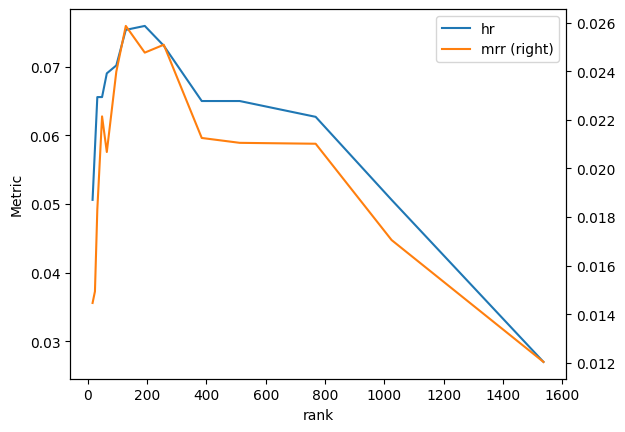

In [310]:
svd_results['hr'].plot(label='hr', legend=True, ylabel='Metric', xlabel='rank')
svd_results['mrr'].plot(secondary_y=True, label='mrr', legend=True);